In [1]:
using CairoMakie, Dierckx, QuantEcon, LinearAlgebra, Optim, ColorSchemes

In [2]:
println("Number of threads: ", Threads.nthreads())

Number of threads: 20


In [3]:
set_theme!(theme_dark())

In [54]:
function create_model_CRRA(;na = 101, nz = 15)

    # Create NamedTuple
    p = (;r = 0.1, # Interest rate
          w = 0.01, # Wage
          β = 0.9, # Discount factor
          γ = 2.0, # Risk aversion
          nz = nz, # Number of productivity grid points
          ρ = 0.9, # AR(1) persistence
          μ = 0.0, # AR(1) mean
          σ = 0.003, # AR(1) standard deviation
          θ = 3.0, # Expanding grid parameter
          na = na, # Number of capital grid points
          lb = 0.0, # Lower bound of capital grid
          ub = 1_000.0, # Upper bound of capital grid
          max_iter = 1_000, # Maximum number of iterations
          how_iter = 50, # Number of Howard policy iterations
          print_skip = 100, # Print frequency
          toler = 4e-7, # Tolerance
          agrid = zeros(Float64, na), # Capital grid
          zgrid = zeros(Float64, nz), # Productivity grid
          Π = zeros(Float64, nz, nz)) # Transition matrix
          
          # Create capital grid
          temp_grid = LinRange(0, 1, p.na)
          agrid = p.lb .+ (p.ub - p.lb) .* temp_grid .^ p.θ
          
          # Create productivity grid
          mc = rouwenhorst(p.nz, p.μ, p.ρ, p.σ)
          zgrid = exp.(mc.state_values)
          Π = mc.p

          # Return NamedTuple
          p = (;p..., agrid = agrid, zgrid = zgrid, Π = Π)

    return p
end

model_CRRA = create_model_CRRA()

(r = 0.1, w = 0.01, β = 0.9, γ = 2.0, nz = 15, ρ = 0.9, μ = 0.0, σ = 0.003, θ = 3.0, na = 101, lb = 0.0, ub = 1000.0, max_iter = 1000, how_iter = 50, print_skip = 100, toler = 4.0e-7, agrid = [0.0, 0.0010000000000000002, 0.008000000000000002, 0.027, 0.06400000000000002, 0.12500000000000003, 0.216, 0.3430000000000001, 0.5120000000000001, 0.729  …  753.5710000000001, 778.6880000000001, 804.3570000000001, 830.5839999999998, 857.3749999999999, 884.736, 912.673, 941.1919999999999, 970.2989999999999, 1000.0], zgrid = [0.03457959025122844, 0.05594303083042085, 0.09050490985451279, 0.14641928737474275, 0.23687784176339377, 0.3832221350379456, 0.6199786509779679, 1.003004504503377, 1.6226656102869836, 2.625156388616362, 4.246990890177603, 6.870802707018247, 11.115618342377728, 17.982901911474734, 29.092826975250997], Π = [6.103515625e-5 0.0008544921875 … 0.0008544921875 6.103515625e-5; 6.103515625e-5 0.0008544921875 … 0.0008544921875 6.103515625e-5; … ; 6.103515625e-5 0.0008544921875 … 0.000854

In [56]:
function utility(c, pars)
    (; γ) = pars
    if γ == 1.0
        return log(c)
    else
        return (c^(1-γ))/(1-γ)
    end
end

function resources(Avals, Zvals, i, j, pars)
    (; r, w) = pars
    return (1+r)*Avals[i]+(w*Zvals[j])
end

function interpV(Avals, v_slice)
    interp_v = Spline1D(Avals, v_slice, k=3, bc="extrapolate")
    return interp_v
end

function optimise(Avals, Zvals, v_init, v_new, policy, Π, pars)
    (; β, na, nz, lb) = pars
    Threads.@threads for j in 1:nz
        expected_value = v_init * Π[j,:]
        interpolation = interpV(Avals, expected_value)
        for i in 1:na
            obj(ap) = - (utility(resources(Avals, Zvals, i, j, pars)-ap, pars)+β*interpolation(ap))
            ub = resources(Avals, Zvals, i, j, pars)  
            res = optimize(obj, lb, ub)
            policy[i,j] = res.minimizer
            v_new[i,j] = -res.minimum
        end
    end
    return v_new, policy
end

function howard(v, policy, Π, Agrid, Zgrid, pars)
    (; β, na, nz, how_iter) = pars
    for _ in 1:how_iter
        for j in 1:nz
            exp_val = v * Π[j,:]
            interp_e_val = interpV(Agrid, exp_val)
            for i in 1:na
                obj(ap) = (utility(resources(Agrid, Zgrid, i, j, pars)-ap, pars)+β*interp_e_val(ap))
                v[i,j] = obj(policy[i,j])
            end
        end
    end
    return v
end        

howard (generic function with 1 method)

Iterating...
--------------------
Iteration: 0, Error: 0.9996543236309601
--------------------
Iteration: 100, Error: 8.180007115477823e-6
--------------------
Converged in 132 iterations
--------------------
  0.371530 seconds (625.47 k allocations: 90.558 MiB, 713.42% compilation time)


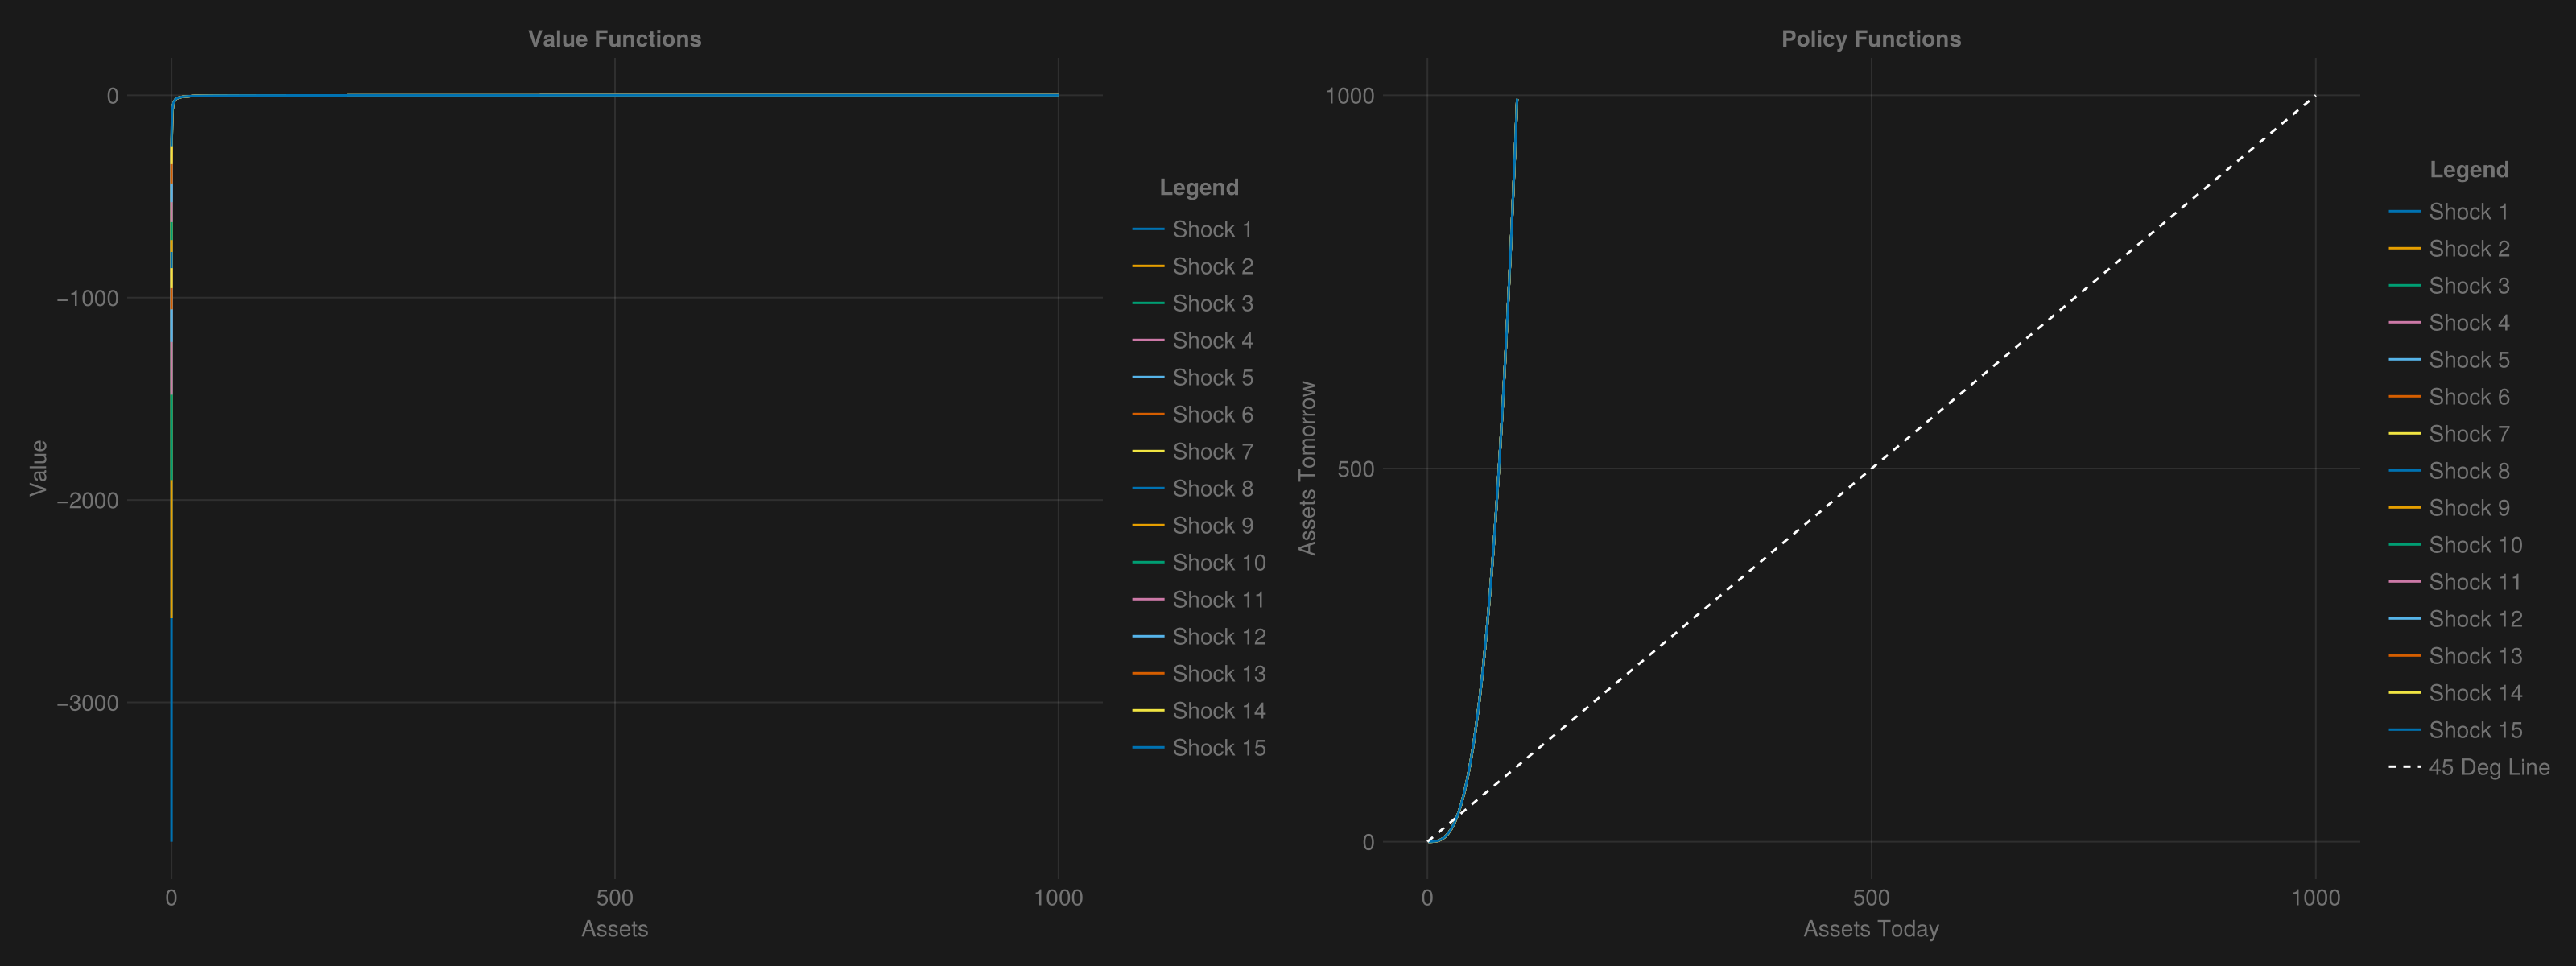

In [57]:
function vfi(pars)
    (; na, nz, agrid, zgrid, Π, max_iter, toler, print_skip) = pars
    v_init = zeros(na, nz)
    v_new = similar(v_init)
    policy = similar(v_init)
    error = toler + 1
    iter = 0
    if iter == 0
        println("Iterating...")
    end
    while ((error > toler) && (iter < max_iter))
        v_new, policy = optimise(agrid, zgrid, v_init, v_new, policy, Π, pars)
        error = maximum(abs.(v_new - v_init) ./ (1 .+ abs.(v_new)))
        v_init .= v_new
        if iter % print_skip == 0
            println("--------------------")
            println("Iteration: $iter, Error: $error")
        end
        iter += 1
    end
    println("--------------------")
    println("Converged in $iter iterations")
    println("--------------------")
    return v_new, policy, agrid

end

@time begin
v_out, pol_out, agrid = vfi(model_CRRA)
end

fig1 = Figure(size = (1600, 600))

ax1 = Axis(fig1[1, 1], title = "Value Functions", xlabel = "Assets", ylabel = "Value")
for j in 1:model_CRRA.nz
    lines!(ax1, agrid, v_out[:,j], label = "Shock $j")
end
legend = Legend(fig1[1,2], ax1, "Legend", orientation = :vertical, fontsize = 4)

ax2 = Axis(fig1[1, 3], title = "Policy Functions", xlabel = "Assets Today", ylabel = "Assets Tomorrow")
for j in 1:model_CRRA.nz
    lines!(ax2, pol_out[:,j], label = "Shock $j")
end
lines!(ax2, agrid, agrid, label = "45 Deg Line", color = :white, linestyle = :dash)
legend = Legend(fig1[1, 4], ax2, "Legend", orientation = :vertical, fontsize = 4)

fig1

Iterating...
--------------------
Iteration: 0, Error: 1.0
--------------------
Iteration: 100, Error: 9188.507548554557
--------------------
Iteration: 200, Error: 0.9532898643891905
--------------------
Iteration: 300, Error: 0.9584678450436395
--------------------
Converged in 353 iterations
--------------------
 12.406974 seconds (3.93 M allocations: 5.626 GiB, 18.70% gc time, 2.34% compilation time)


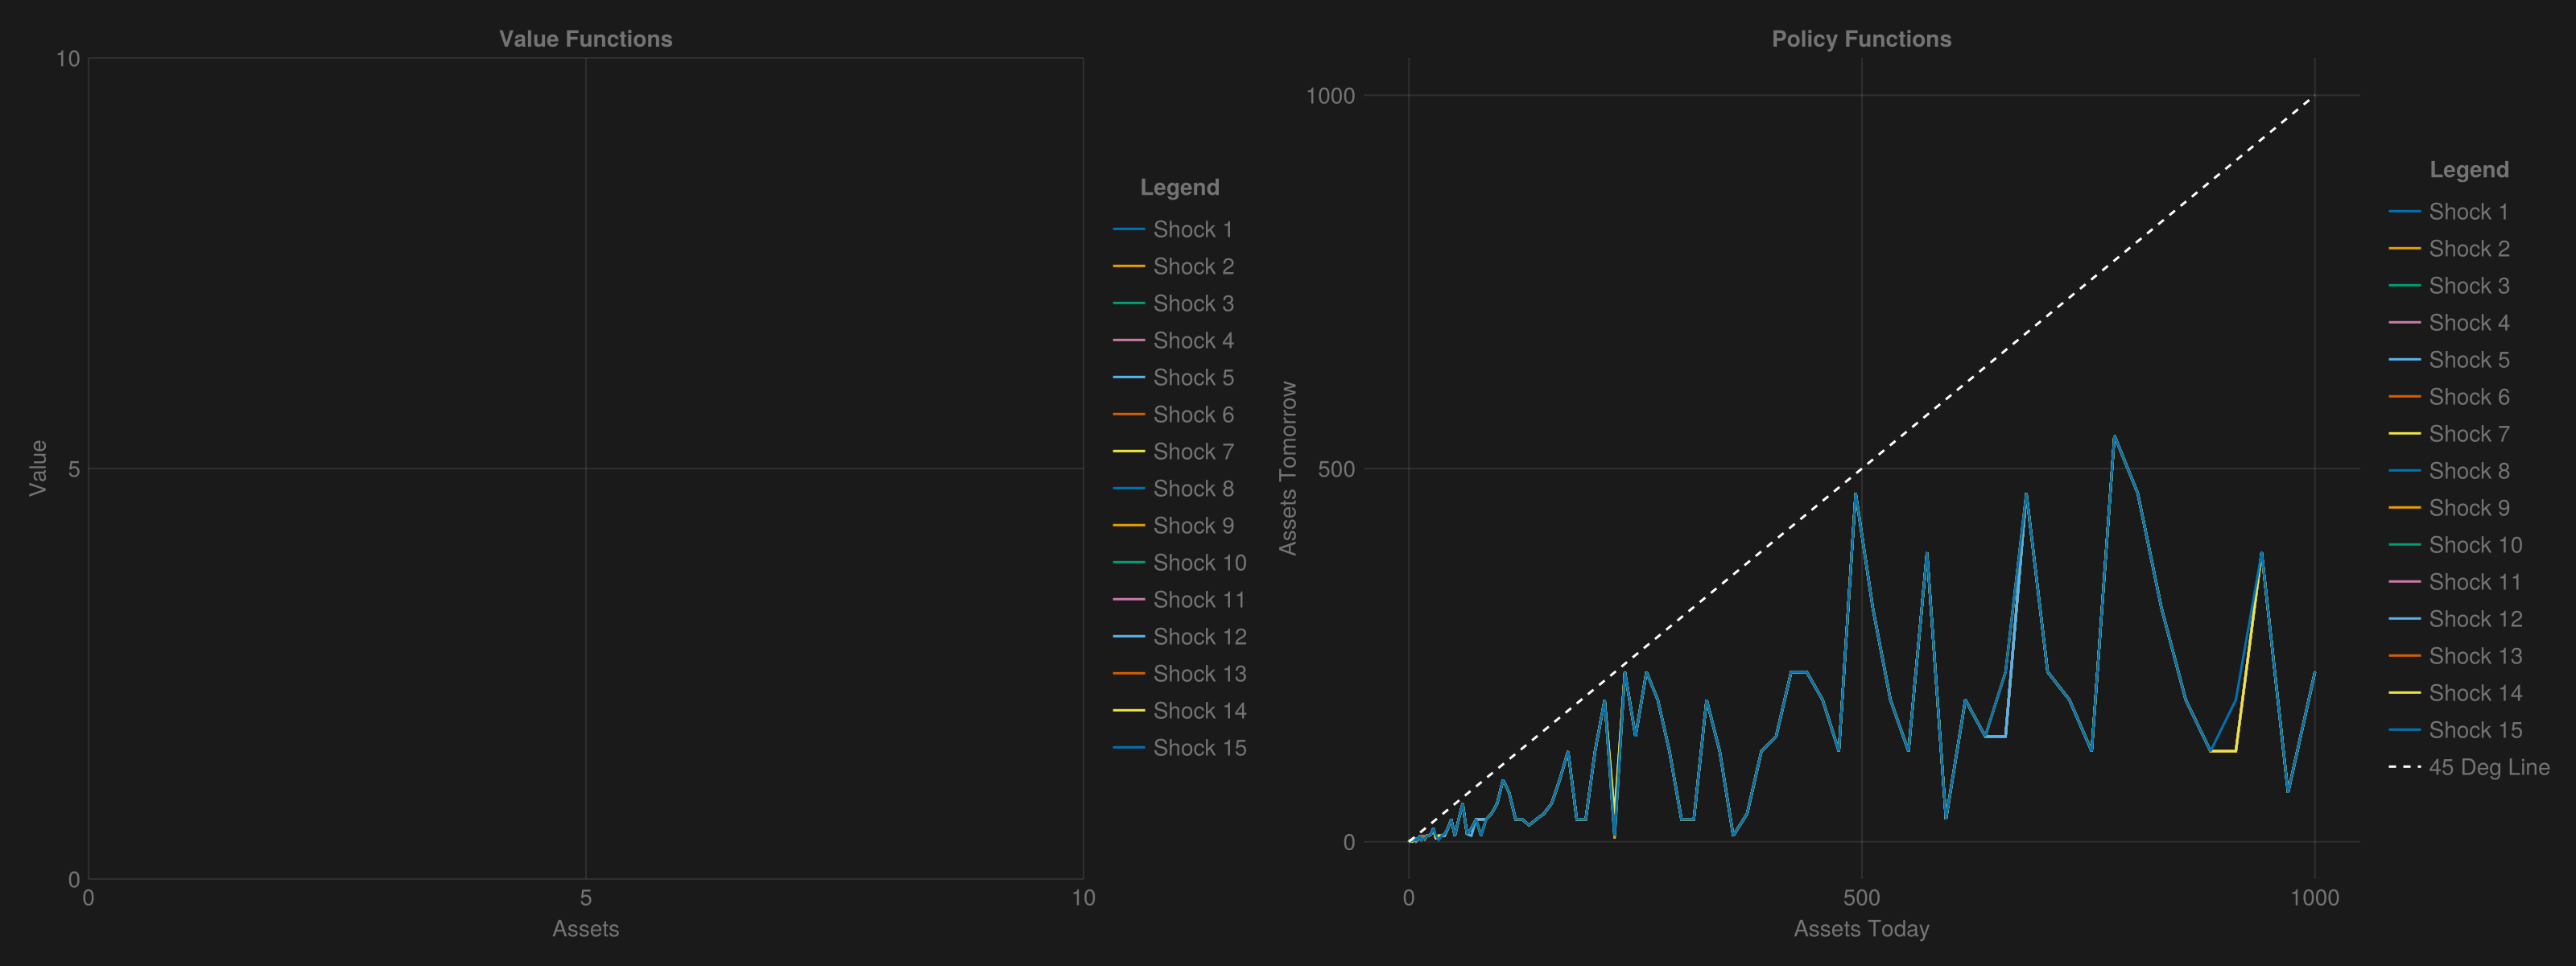

In [31]:
function hpi(pars)
    (; na, nz, agrid, zgrid, Π, max_iter, toler, print_skip) = pars
    v_init = ones(na, nz)
    v_new = similar(v_init)
    policy = similar(v_init)
    error = toler + 1
    iter = 0
    if iter == 0
        println("Iterating...")
    end
    while ((error > toler) && (iter < max_iter))
        v_new, policy = optimise(agrid, zgrid, v_init, v_new, policy, Π, pars)
        v_new = howard(v_new, policy, Π, agrid, zgrid, pars)
        error = maximum(abs.(v_new - v_init) ./ (1 .+ abs.(v_new)))
        v_init .= v_new
        if iter % print_skip == 0
            println("--------------------")
            println("Iteration: $iter, Error: $error")
        end
        iter += 1
    end
    println("--------------------")
    println("Converged in $iter iterations")
    println("--------------------")

    return v_new, policy, agrid

end
        
@time begin
    hpi_v, hpi_pol, agrid = hpi(model_CRRA)
end  

fig1 = Figure(size = (1600, 600))

ax1 = Axis(fig1[1, 1], title = "Value Functions", xlabel = "Assets", ylabel = "Value")
for j in 1:model_CRRA.nz
    lines!(ax1, agrid, hpi_v[:,j], label = "Shock $j")
end
legend = Legend(fig1[1,2], ax1, "Legend", orientation = :vertical, fontsize = 4)

ax2 = Axis(fig1[1, 3], title = "Policy Functions", xlabel = "Assets Today", ylabel = "Assets Tomorrow")
for j in 1:model_CRRA.nz
    lines!(ax2, agrid, hpi_pol[:,j], label = "Shock $j")
end
lines!(ax2, agrid, agrid, label = "45 Deg Line", color = :white, linestyle = :dash)
legend = Legend(fig1[1, 4], ax2, "Legend", orientation = :vertical, fontsize = 4)

fig1

In [32]:
function create_model_CES(;na = 101, nz = 15)

    # Create NamedTuple
    p = (;r = 0.05, # Interest rate
          w = 0.009, # Wage
          β = 0.9, # Discount factor
          γ = 2.0, # Risk aversion (must be >1)
          nz = nz, # Number of productivity grid points
          ρ = 0.9, # AR(1) persistence
          μ = 0.0, # AR(1) mean
          σ = 0.003, # AR(1) standard deviation
          θ = 3.0, # Expanding grid parameter
          na = na, # Number of capital grid points
          lb = 0.0, # Lower bound of capital grid
          ub = 1_000.0, # Upper bound of capital grid
          max_iter = 1_000, # Maximum number of iterations
          how_iter = 25, # Number of Howard policy iterations
          print_skip = 100, # Print frequency
          toler = 4e-7, # Tolerance
          agrid = zeros(Float64, na), # Capital grid
          zgrid = zeros(Float64, nz), # Productivity grid
          Π = zeros(Float64, nz, nz)) # Transition matrix
          
          # Create capital grid
          temp_grid = LinRange(0, 1, p.na)
          agrid = p.lb .+ (p.ub - p.lb) .* temp_grid .^ p.θ
          
          # Create productivity grid
          mc = rouwenhorst(p.nz, p.μ, p.ρ, p.σ)
          zgrid = exp.(mc.state_values)
          Π = mc.p

          # Return NamedTuple
          p = (;p..., agrid = agrid, zgrid = zgrid, Π = Π)

    return p
end

model_CES = create_model_CES()

(r = 0.05, w = 0.009, β = 0.9, γ = 2.0, nz = 15, ρ = 0.9, μ = 0.0, σ = 0.003, θ = 3.0, na = 101, lb = 0.0, ub = 1000.0, max_iter = 1000, how_iter = 25, print_skip = 100, toler = 4.0e-7, agrid = [0.0, 0.0010000000000000002, 0.008000000000000002, 0.027, 0.06400000000000002, 0.12500000000000003, 0.216, 0.3430000000000001, 0.5120000000000001, 0.729  …  753.5710000000001, 778.6880000000001, 804.3570000000001, 830.5839999999998, 857.3749999999999, 884.736, 912.673, 941.1919999999999, 970.2989999999999, 1000.0], zgrid = [0.03457959025122844, 0.05594303083042085, 0.09050490985451279, 0.14641928737474275, 0.23687784176339377, 0.3832221350379456, 0.6199786509779679, 1.003004504503377, 1.6226656102869836, 2.625156388616362, 4.246990890177603, 6.870802707018247, 11.115618342377728, 17.982901911474734, 29.092826975250997], Π = [6.103515625e-5 0.0008544921875 … 0.0008544921875 6.103515625e-5; 6.103515625e-5 0.0008544921875 … 0.0008544921875 6.103515625e-5; … ; 6.103515625e-5 0.0008544921875 … 0.0008

In [38]:
function utility_CES(c, p)
    (; γ) = p
    return c^(1-γ)
end

function interpV_CES(Avals, v_slice, p)
    (; γ) = p
    interp_v = Spline1D(Avals, v_slice, k=1, bc="extrapolate")
    transformed_interp(x) = interp_v(x)^(1.0-γ)
    return transformed_interp
end

function optimise_CES(Avals, Zvals, v_init, v_new, policy, Π, p)
    (; β, na, nz, lb, γ) = p
    Threads.@threads for j in 1:nz
        expected_value = v_init * Π[j,:]
        interpolation = interpV_CES(Avals, expected_value, p)
        for i in 1:na
            obj_CES(ap) = - (((1-β) * utility_CES(resources(Avals, Zvals, i, j, p) - ap, p) + β * interpolation(ap))^(1/(1-γ)))
            ub = resources(Avals, Zvals, i, j, p)  
            res = optimize(obj_CES, lb, ub)
            policy[i,j] = res.minimizer
            v_new[i,j] = -res.minimum
        end
    end
    return v_new, policy
end

function howard_CES(v, policy, Π, Agrid, Zgrid, p)
    (; β, na, nz, how_iter, γ) = p
    for _ in 1:how_iter
        for j in 1:nz
            exp_val = v * Π[j,:]
            interp_e_val = interpV_CES(Agrid, exp_val, p)
            for i in 1:na
                obj_CES(ap) = (((1-β) * utility_CES(resources(Agrid, Zgrid, i, j, p) - ap, p) + β * interp_e_val(ap)))^(1/(1-γ))
                v[i,j] = obj_CES(policy[i,j])
            end
        end
    end
    return v
end  

howard_CES (generic function with 1 method)

Iterating...
--------------------
Iteration: 0, Error: 0.9938122625267023
--------------------
Iteration: 100, Error: 8.899287731449764e-5
--------------------
Converged in 165 iterations
--------------------
  0.241642 seconds (645.97 k allocations: 87.923 MiB, 59.96% compilation time)


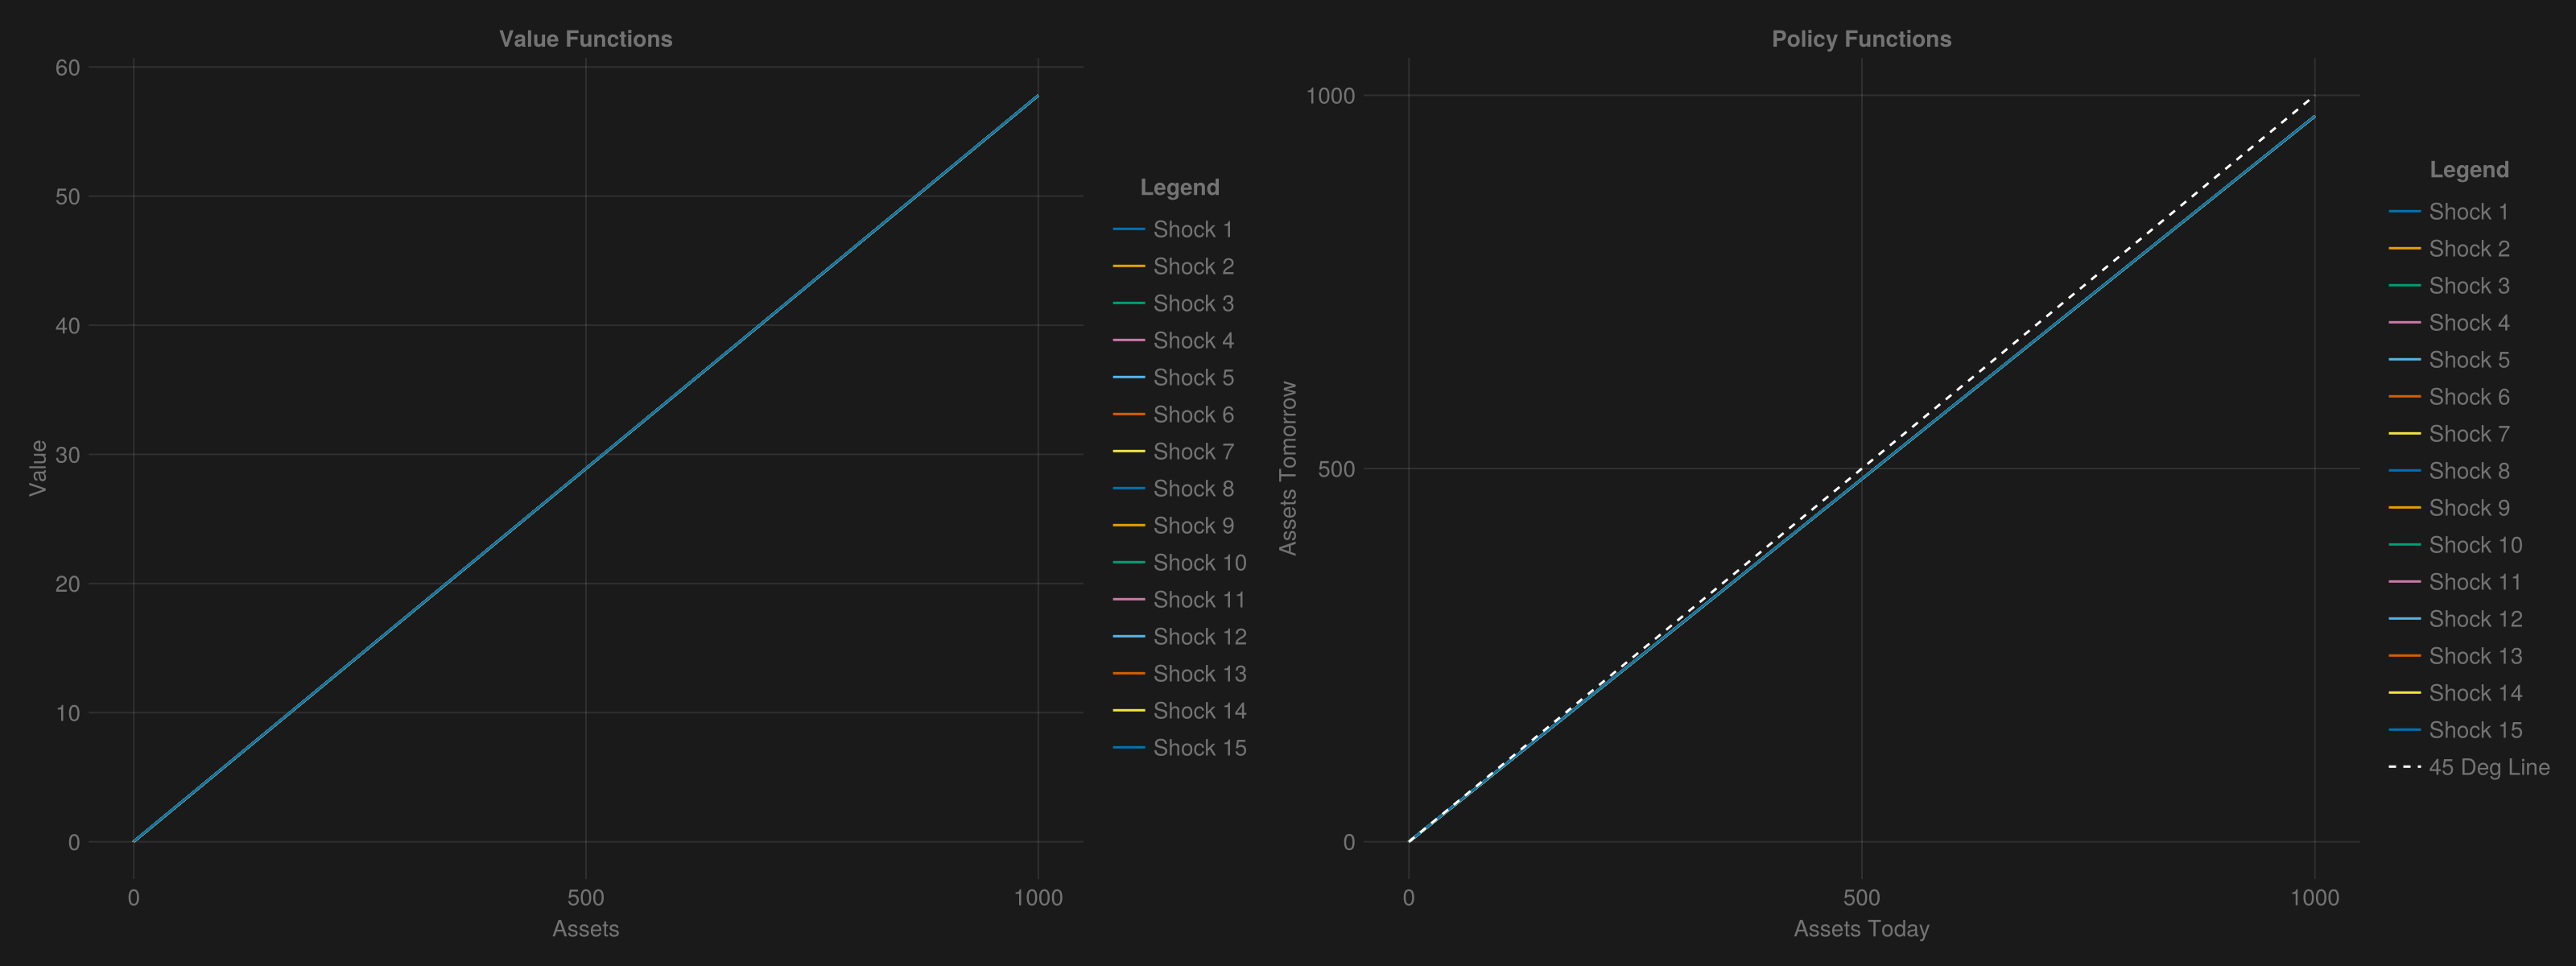

In [41]:
function vfi_CES(p)
    (; na, nz, agrid, zgrid, Π, max_iter, toler, print_skip) = p
    v_init = ones(na, nz)
    v_new = similar(v_init)
    policy = similar(v_init)
    error = toler + 1
    iter = 0
    if iter == 0
        println("Iterating...")
    end
    while ((error > toler) && (iter < max_iter))
        v_new, policy = optimise_CES(agrid, zgrid, v_init, v_new, policy, Π, p)
        error = maximum(abs.(v_new - v_init) ./ (1 .+ abs.(v_new)))
        v_init .= v_new
        if iter % print_skip == 0
            println("--------------------")
            println("Iteration: $iter, Error: $error")
        end
        iter += 1
    end
    println("--------------------")
    println("Converged in $iter iterations")
    println("--------------------")

    return v_new, policy, agrid

end

@time begin
v_ces, pol_ces, agrid = vfi_CES(model_CES)
end

fig1 = Figure(size = (1600, 600))

ax1 = Axis(fig1[1, 1], title = "Value Functions", xlabel = "Assets", ylabel = "Value")
for j in 1:model_CES.nz
    lines!(ax1, agrid, v_ces[:,j], label = "Shock $j")
end
legend = Legend(fig1[1, 2], ax1, "Legend", orientation = :vertical, fontsize = 4)

ax2 = Axis(fig1[1, 3], title = "Policy Functions", xlabel = "Assets Today", ylabel = "Assets Tomorrow")
for j in 1:model_CES.nz
    lines!(ax2, agrid, pol_ces[:,j], label = "Shock $j")
end
lines!(ax2, agrid, agrid, label = "45 Deg Line", color = :white, linestyle = :dash)
legend = Legend(fig1[1, 4], ax2, "Legend", orientation = :vertical, fontsize = 4)

fig1

Iterating...
--------------------
Iteration: 0, Error: 0.9955959962763513
--------------------
Converged in 12 iterations
--------------------
  0.311465 seconds (186.55 k allocations: 78.431 MiB, 12.88% gc time, 49.60% compilation time)


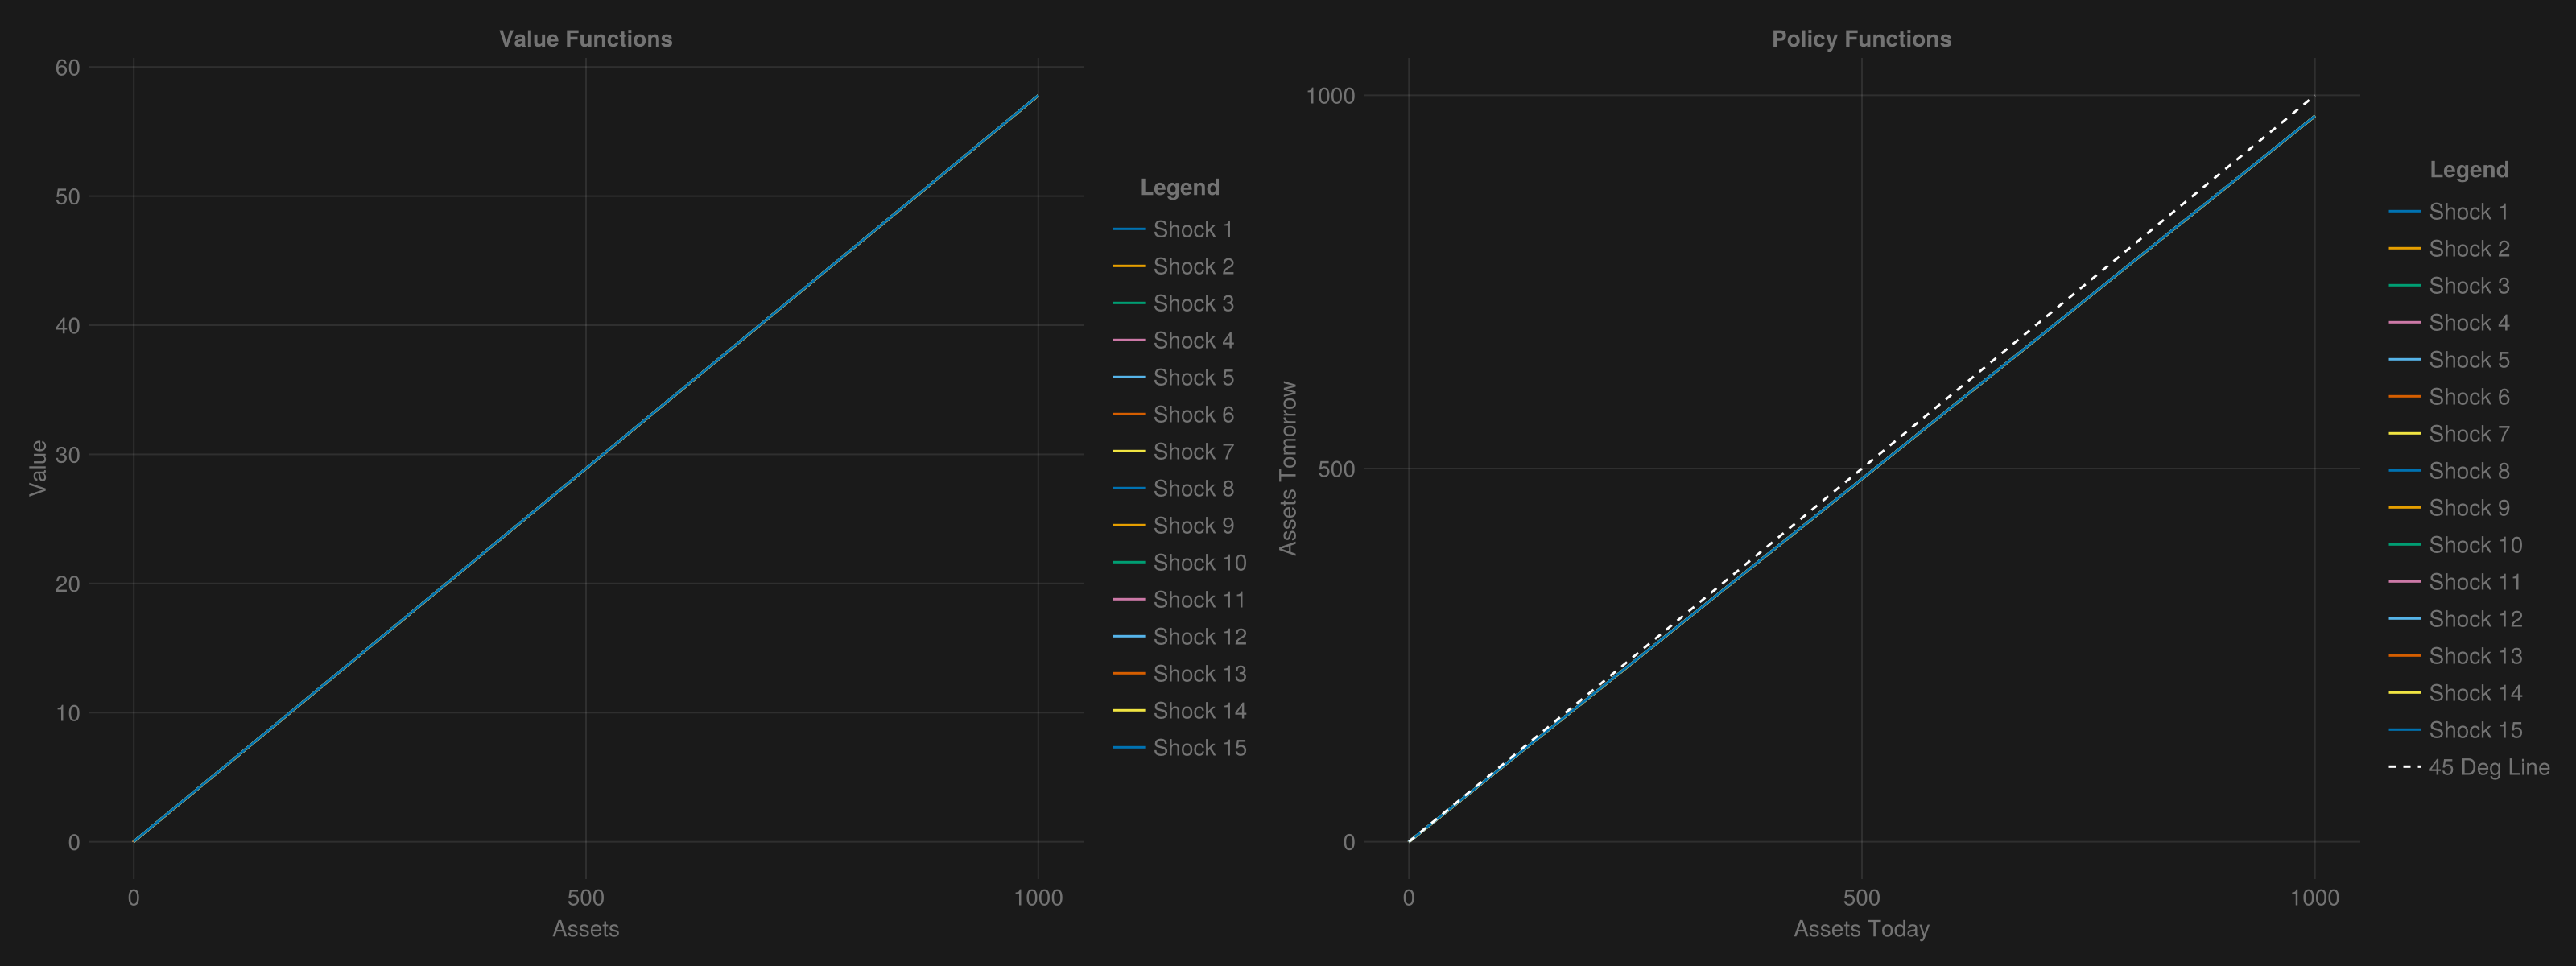

In [42]:
function hpi_CES(p)
    (; na, nz, agrid, zgrid, Π, max_iter, toler, print_skip) = p
    v_init = ones(na, nz)
    v_new = similar(v_init)
    policy = similar(v_init)
    error = toler + 1
    iter = 0
    if iter == 0
        println("Iterating...")
    end
    while ((error > toler) && (iter < max_iter))
        v_new, policy = optimise_CES(agrid, zgrid, v_init, v_new, policy, Π, p)
        v_new = howard_CES(v_new, policy, Π, agrid, zgrid, p)
        error = maximum(abs.(v_new - v_init) ./ (1 .+ abs.(v_new)))
        v_init .= v_new
        if iter % print_skip == 0
            println("--------------------")
            println("Iteration: $iter, Error: $error")
        end
        iter += 1
    end
    println("--------------------")
    println("Converged in $iter iterations")
    println("--------------------")

    return v_new, policy, agrid

end

@time begin
    hpi_v_CES, hpi_pol_CES, agrid = hpi_CES(model_CES)
end

fig1 = Figure(size = (1600, 600))

ax1 = Axis(fig1[1, 1], title = "Value Functions", xlabel = "Assets", ylabel = "Value")
for j in 1:model_CES.nz
    lines!(ax1, agrid, hpi_v_CES[:,j], label = "Shock $j")
end
legend = Legend(fig1[1, 2], ax1, "Legend", orientation = :vertical, fontsize = 4)

ax2 = Axis(fig1[1, 3], title = "Policy Functions", xlabel = "Assets Today", ylabel = "Assets Tomorrow")
for j in 1:model_CES.nz
    lines!(ax2, agrid, hpi_pol_CES[:,j], label = "Shock $j")
end
lines!(ax2, agrid, agrid, label = "45 Deg Line", color = :white, linestyle = :dash)
legend = Legend(fig1[1, 4], ax2, "Legend", orientation = :vertical, fontsize = 4)

fig1